In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-09 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.13.1
matplotlib 3.1.0
imblearn 0.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle

# Load datasets

In [3]:
datasets = pd.DataFrame()
for i in range(1,6):
    print(i)
    dump = pd.read_csv("../../data/labeled ({}).csv".format(i), engine='python')
    datasets = pd.concat([datasets, dump])
datasets.head()

1
2
3
4
5


,comment,url_id,label
0,아 이거 웃기네 ㅋㅋㅋ,56,0
1,슬,36,0
2,32.3 ㄷ,17,0
3,팬미팅이넹,56,1
4,빠꾸가 없네 이 둠피,27,0


In [4]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 2999
Data columns (total 3 columns):
comment    15000 non-null object
url_id     15000 non-null int64
label      15000 non-null int64
dtypes: int64(2), object(1)
memory usage: 468.8+ KB


In [5]:
datasets.reset_index(drop=True,inplace=True)

In [6]:
datasets.label = datasets.label.astype('int')

In [7]:
len(datasets[datasets.label ==1])/ len(datasets) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향ㅠㅠ

0.043666666666666666

In [8]:
datasets.rename(columns={'comment':'chat'}, inplace=True)

# Tokenize
## 형태소분석

In [9]:
morp = Okt()

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [10]:
morped = [morp.morphs(_, norm=True, stem=True) for _ in tqdm(datasets.chat)] # Stemming은 하지 않는다.

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:34<00:00, 436.68it/s]


In [11]:
morped[:5]

[['아', '이', '거', '웃기', '네', 'ㅋㅋㅋ'],
 ['슬'],
 ['32.3', 'ㄷ'],
 ['팬미팅', '이', '넹'],
 ['빠꾸', '가', '없다', '이', '두다', '피']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [38]:
vocab_size = 10000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# vocab save
with open('./vocab/vocab_index.pickle', 'wb') as f:
    pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
    pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
ㅋㅋㅋ :  2823
? :  1108
이 :  1103
하다 :  840
! :  395
ㅋㅋ :  391
가 :  384
오다 :  363
아 :  299
이다 :  294

단어 사전:
0 <PAD>
1 <OOV>
2 ㅋㅋㅋ
3 ?
4 이
5 하다
6 !
7 ㅋㅋ
8 가
9 오다

단어 사전 크기:  8000


In [39]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['아', '이', '거', '웃기', '네', 'ㅋㅋㅋ']
문자 -> 숫자:  [10, 4, 28, 946, 22, 2]
숫자 -> 문자:  아 이 거 웃기 네 ㅋㅋㅋ


# Padding

In [150]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 10
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [151]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [152]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

In [153]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## upsampling
- 딥러닝은 데이터가 많을수록 좋다.
- 보다 많은 데이터 사용을 위해 upsampling을 사용하자!

In [154]:
up_X, up_y = RandomOverSampler().fit_resample(x_padded, datasets.label)
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(up_X, up_y)

# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(28690, 14345)

In [155]:
model_up = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 21517 samples, validate on 7173 samples
Epoch 1/5
21517/21517 [==============================] - ETA: 18:27 - loss: 0.6964 - recall_16: 0.56 - ETA: 3:47 - loss: 0.6928 - recall_16: 0.6000 - ETA: 2:25 - loss: 0.6927 - recall_16: 0.582 - ETA: 1:39 - loss: 0.6923 - recall_16: 0.567 - ETA: 1:16 - loss: 0.6928 - recall_16: 0.548 - ETA: 1:06 - loss: 0.6928 - recall_16: 0.547 - ETA: 55s - loss: 0.6932 - recall_16: 0.527 - ETA: 48s - loss: 0.6933 - recall_16: 0.51 - ETA: 44s - loss: 0.6934 - recall_16: 0.51 - ETA: 40s - loss: 0.6931 - recall_16: 0.50 - ETA: 37s - loss: 0.6932 - recall_16: 0.49 - ETA: 33s - loss: 0.6934 - recall_16: 0.48 - ETA: 30s - loss: 0.6932 - recall_16: 0.48 - ETA: 28s - loss: 0.6930 - recall_16: 0.47 - ETA: 26s - loss: 0.6927 - recall_16: 0.47 - ETA: 25s - loss: 0.6926 - recall_16: 0.47 - ETA: 23s - loss: 0.6925 - recall_16: 0.48 - ETA: 23s - loss: 0.6924 - recall_16: 0.48 - ETA: 22s - loss: 0.6923 - recall_16: 0.48 - ETA: 21s - loss: 0.6921 - recall_16: 0.48 - 

Epoch 2/5
21517/21517 [==============================] - ETA: 8s - loss: 0.1241 - recall_16: 0.968 - ETA: 9s - loss: 0.1238 - recall_16: 0.962 - ETA: 8s - loss: 0.1823 - recall_16: 0.950 - ETA: 8s - loss: 0.1718 - recall_16: 0.950 - ETA: 10s - loss: 0.1723 - recall_16: 0.94 - ETA: 9s - loss: 0.1557 - recall_16: 0.9524 - ETA: 8s - loss: 0.1470 - recall_16: 0.956 - ETA: 8s - loss: 0.1365 - recall_16: 0.962 - ETA: 8s - loss: 0.1371 - recall_16: 0.963 - ETA: 9s - loss: 0.1440 - recall_16: 0.962 - ETA: 9s - loss: 0.1521 - recall_16: 0.960 - ETA: 9s - loss: 0.1490 - recall_16: 0.962 - ETA: 9s - loss: 0.1497 - recall_16: 0.964 - ETA: 9s - loss: 0.1448 - recall_16: 0.965 - ETA: 9s - loss: 0.1488 - recall_16: 0.964 - ETA: 9s - loss: 0.1522 - recall_16: 0.963 - ETA: 9s - loss: 0.1525 - recall_16: 0.963 - ETA: 9s - loss: 0.1514 - recall_16: 0.963 - ETA: 9s - loss: 0.1532 - recall_16: 0.962 - ETA: 9s - loss: 0.1544 - recall_16: 0.961 - ETA: 9s - loss: 0.1557 - recall_16: 0.961 - ETA: 8s - loss: 0.

21184/21517 [============================>.] - ETA: 7s - loss: 0.0156 - recall_16: 1.000 - ETA: 8s - loss: 0.0546 - recall_16: 0.981 - ETA: 8s - loss: 0.0616 - recall_16: 0.975 - ETA: 9s - loss: 0.0565 - recall_16: 0.976 - ETA: 9s - loss: 0.0615 - recall_16: 0.976 - ETA: 9s - loss: 0.0591 - recall_16: 0.979 - ETA: 9s - loss: 0.0664 - recall_16: 0.980 - ETA: 9s - loss: 0.0728 - recall_16: 0.976 - ETA: 9s - loss: 0.0666 - recall_16: 0.979 - ETA: 9s - loss: 0.0692 - recall_16: 0.978 - ETA: 9s - loss: 0.0679 - recall_16: 0.979 - ETA: 8s - loss: 0.0671 - recall_16: 0.979 - ETA: 8s - loss: 0.0649 - recall_16: 0.980 - ETA: 8s - loss: 0.0663 - recall_16: 0.979 - ETA: 8s - loss: 0.0654 - recall_16: 0.979 - ETA: 8s - loss: 0.0629 - recall_16: 0.981 - ETA: 8s - loss: 0.0626 - recall_16: 0.981 - ETA: 8s - loss: 0.0623 - recall_16: 0.981 - ETA: 8s - loss: 0.0620 - recall_16: 0.981 - ETA: 8s - loss: 0.0638 - recall_16: 0.980 - ETA: 9s - loss: 0.0633 - recall_16: 0.981 - ETA: 9s - loss: 0.0624 - reca

21517/21517 [==============================] - ETA: 0s - loss: 0.0754 - recall_16: 0.978 - ETA: 0s - loss: 0.0756 - recall_16: 0.978 - 12s 544us/sample - loss: 0.0754 - recall_16: 0.9783 - val_loss: 0.0950 - val_recall_16: 0.9770
Epoch 4/5
21517/21517 [==============================] - ETA: 8s - loss: 0.0033 - recall_16: 1.000 - ETA: 10s - loss: 0.0496 - recall_16: 0.99 - ETA: 11s - loss: 0.0546 - recall_16: 0.97 - ETA: 9s - loss: 0.0557 - recall_16: 0.9792 - ETA: 9s - loss: 0.0615 - recall_16: 0.978 - ETA: 9s - loss: 0.0764 - recall_16: 0.976 - ETA: 9s - loss: 0.0692 - recall_16: 0.978 - ETA: 9s - loss: 0.0630 - recall_16: 0.981 - ETA: 8s - loss: 0.0674 - recall_16: 0.980 - ETA: 8s - loss: 0.0616 - recall_16: 0.982 - ETA: 8s - loss: 0.0627 - recall_16: 0.981 - ETA: 8s - loss: 0.0626 - recall_16: 0.982 - ETA: 8s - loss: 0.0593 - recall_16: 0.983 - ETA: 8s - loss: 0.0582 - recall_16: 0.983 - ETA: 8s - loss: 0.0569 - recall_16: 0.983 - ETA: 8s - loss: 0.0553 - recall_16: 0.983 - ETA: 8s 

21517/21517 [==============================] - ETA: 7s - loss: 0.0185 - recall_16: 1.000 - ETA: 7s - loss: 0.0421 - recall_16: 0.994 - ETA: 8s - loss: 0.0341 - recall_16: 0.993 - ETA: 8s - loss: 0.0406 - recall_16: 0.991 - ETA: 8s - loss: 0.0366 - recall_16: 0.991 - ETA: 8s - loss: 0.0411 - recall_16: 0.990 - ETA: 8s - loss: 0.0411 - recall_16: 0.987 - ETA: 8s - loss: 0.0445 - recall_16: 0.985 - ETA: 8s - loss: 0.0431 - recall_16: 0.986 - ETA: 8s - loss: 0.0395 - recall_16: 0.987 - ETA: 8s - loss: 0.0392 - recall_16: 0.987 - ETA: 8s - loss: 0.0383 - recall_16: 0.987 - ETA: 8s - loss: 0.0380 - recall_16: 0.988 - ETA: 8s - loss: 0.0378 - recall_16: 0.988 - ETA: 8s - loss: 0.0365 - recall_16: 0.989 - ETA: 8s - loss: 0.0386 - recall_16: 0.988 - ETA: 8s - loss: 0.0378 - recall_16: 0.989 - ETA: 8s - loss: 0.0368 - recall_16: 0.989 - ETA: 8s - loss: 0.0363 - recall_16: 0.989 - ETA: 8s - loss: 0.0398 - recall_16: 0.988 - ETA: 8s - loss: 0.0395 - recall_16: 0.988 - ETA: 7s - loss: 0.0388 - reca

7173/7173 [==============================] - ETA: 0s - loss: 0.0634 - recall_16: 0.968 - ETA: 0s - loss: 0.1063 - recall_16: 0.977 - ETA: 0s - loss: 0.1340 - recall_16: 0.974 - ETA: 0s - loss: 0.0999 - recall_16: 0.978 - ETA: 0s - loss: 0.0893 - recall_16: 0.980 - ETA: 0s - loss: 0.0821 - recall_16: 0.981 - ETA: 0s - loss: 0.0935 - recall_16: 0.980 - ETA: 0s - loss: 0.0999 - recall_16: 0.980 - ETA: 0s - loss: 0.1023 - recall_16: 0.979 - ETA: 0s - loss: 0.0950 - recall_16: 0.980 - ETA: 0s - loss: 0.0921 - recall_16: 0.979 - ETA: 0s - loss: 0.0902 - recall_16: 0.980 - ETA: 0s - loss: 0.0950 - recall_16: 0.978 - ETA: 0s - loss: 0.0889 - recall_16: 0.979 - ETA: 0s - loss: 0.0882 - recall_16: 0.978 - ETA: 0s - loss: 0.0896 - recall_16: 0.978 - ETA: 0s - loss: 0.0940 - recall_16: 0.978 - ETA: 0s - loss: 0.0918 - recall_16: 0.978 - ETA: 0s - loss: 0.0954 - recall_16: 0.978 - 1s 136us/sample - loss: 0.0951 - recall_16: 0.9781
Test accuracy: 0.97811234


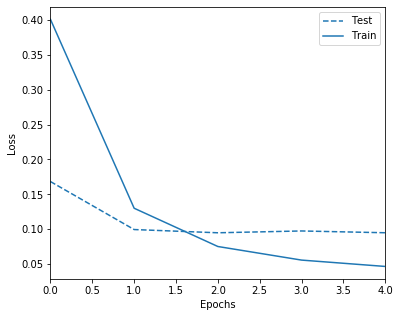

In [156]:
model_up.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_up.fit(up_X_train,
          pd.get_dummies(up_y_train),
          epochs=5,
          validation_data=(up_X_test, pd.get_dummies(up_y_test))
         )
plot_loss(history)
test_loss, test_acc = model_up.evaluate(up_X_test, pd.get_dummies(up_y_test))
print('Test accuracy:', test_acc)

In [157]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, up_X_test))
result['predict'] = model_up.predict_proba(up_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = up_y_test

전체채팅수7173, 유해채팅수3752


In [158]:
# result.to_csv('../../data/cnn_result.csv', encoding='utf-16')

## 분류 애매한 채팅들

In [162]:
result[(result.predict>0.4) & (result.predict<0.6)]

,0,predict,label
19,이즈 <OOV> 좋다 ~ <PAD> <PAD> <PAD>,0.494528,0
221,근데 그 방송 이 뭐 인지 모르다 그렇다 같다 !!!!!,0.432845,0
234,가붕 아 <PAD> <PAD> <PAD> <PAD> <PA,0.446143,0
944,나 누누 나 죽다 <PAD> <PAD> <PAD> <PAD,0.515595,1
948,<OOV> ㄷㄷ <PAD> <PAD> <PAD> <PAD>,0.499224,0
1494,미드 kda 1 위 ㄷㄷ <PAD> <PAD> <PAD>,0.552478,0
1860,나 누누 나 죽다 <PAD> <PAD> <PAD> <PAD,0.515595,1
1916,가붕이 는 이기다 없다 ㅠㅠ <PAD> <PAD> <PAD,0.468964,0
1974,나 누누 나 죽다 <PAD> <PAD> <PAD> <PAD,0.515595,1
2072,나 누누 나 죽다 <PAD> <PAD> <PAD> <PAD,0.515595,1


### 예측 실패한 채팅들

In [163]:
result[model_up.predict_classes(up_X_test) != up_y_test]

,0,predict,label
23,지다 <PAD> <PAD> <PAD> <PAD> <PAD>,0.673683,0
56,방금 들 렷음 <PAD> <PAD> <PAD> <PAD>,0.954105,0
68,찬밥 이형 근데 <OOV> 빨 고 하다 이 상태 로,0.972861,0
90,무수 한 핑 의 요청 이 <PAD> <PAD> <PAD>,0.994825,0
110,삼 개다 시너지 <PAD> <PAD> <PAD> <PAD>,0.937835,0
171,노노노 ㅗ <OOV> 노노노 ㅗ <OOV> <PAD> <P,0.999683,0
303,입 벌리다 뻔 하다 <PAD> <PAD> <PAD> <PA,0.999978,0
381,애니비아 무시 ? <PAD> <PAD> <PAD> <PAD,0.995982,0
426,<OOV> <PAD> <PAD> <PAD> <PAD> <P,0.370348,1
438,<OOV> <PAD> <PAD> <PAD> <PAD> <P,0.370348,1


# 시11111발 의 경우

In [169]:
test_chat = "시발년아이게찰진욕이야이새끼야나가뒤져"
test_id = text_to_index(morp.morphs(test_chat, norm=True, stem=True))
print(morp.morphs(test_chat, norm=True, stem=True))
sentence_size = 20
x_padded_temp = sequence.pad_sequences([test_id],
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
model_up.predict(x_padded_temp)

['시발', '년', '아이', '게', '찰지다', '욕', '이야', '이', '새끼', '야', '나가다', '뒤지다']


array([[0.00155474, 0.99803215]], dtype=float32)

## Downsampling

In [170]:
down_X, down_y = RandomUnderSampler().fit_resample(x_padded, datasets.label)
down_X_train, down_X_test, down_y_train, down_y_test = train_test_split(down_X, down_y)

# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(1310, 655)

In [171]:
model_down = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 982 samples, validate on 328 samples
Epoch 1/7
982/982 [==============================] - ETA: 1:00 - loss: 0.3961 - recall_18: 0.875 - ETA: 8s - loss: 0.3702 - recall_18: 0.8750  - ETA: 5s - loss: 0.3646 - recall_18: 0.868 - ETA: 3s - loss: 0.3731 - recall_18: 0.872 - ETA: 2s - loss: 0.3671 - recall_18: 0.879 - ETA: 1s - loss: 0.3595 - recall_18: 0.883 - ETA: 0s - loss: 0.3599 - recall_18: 0.881 - ETA: 0s - loss: 0.3616 - recall_18: 0.879 - ETA: 0s - loss: 0.3554 - recall_18: 0.881 - 3s 3ms/sample - loss: 0.3574 - recall_18: 0.8798 - val_loss: 0.5657 - val_recall_18: 0.6951
Epoch 2/7
982/982 [==============================] - ETA: 0s - loss: 0.2149 - recall_18: 1.000 - ETA: 0s - loss: 0.2995 - recall_18: 0.887 - ETA: 0s - loss: 0.2852 - recall_18: 0.906 - ETA: 0s - loss: 0.2910 - recall_18: 0.915 - ETA: 0s - loss: 0.2988 - recall_18: 0.910 - ETA: 0s - loss: 0.2973 - recall_18: 0.909 - ETA: 0s - loss: 0.2945 - recall_18: 0.910 - ETA: 0s - loss: 0.2973 - recall_18: 0.907 - 0s 4

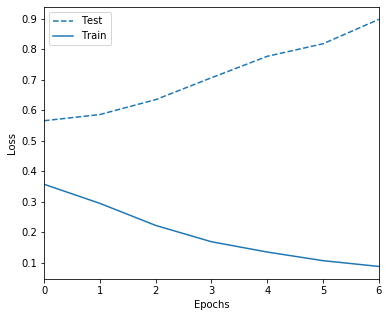

In [176]:
model_down.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_down.fit(down_X_train,
          pd.get_dummies(down_y_train),
          epochs=7,
          validation_data=(down_X_test, pd.get_dummies(down_y_test))
         )
plot_loss(history)
test_loss, test_acc = model_down.evaluate(down_X_test, pd.get_dummies(down_y_test))
print('Test Recall:', test_acc)

In [177]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, down_X_test))
result['predict'] = model_down.predict_proba(down_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = down_y_test

전체채팅수328, 유해채팅수180


In [178]:
# 예측 실패 채팅
result[model_down.predict_classes(down_X_test) != down_y_test]

,0,predict,label
2,미애 눈치 주네 창석 이 련 <PAD> <PAD> <PAD> <PAD>,0.999625,0
4,봉신 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <...,0.124960,1
6,뿌직 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <...,0.084351,1
11,캬아 아 ㅏㅏ <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>,0.776006,0
17,개욱기 네 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD...,0.289622,1
18,되다 라나 ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>,0.977353,0
19,애 들 이 진짜 시르다 하자 나 <PAD> <PAD> <PAD>,0.999999,0
21,야겜 ㄷㄷ <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD...,0.062577,1
29,뇌절 ㅋㅋ <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD...,0.188417,1
32,양 팀 경기 력 장난 아니다 <PAD> <PAD> <PAD> <PAD>,0.999972,0


In [190]:
test_chat = "미애"
test_id = text_to_index(morp.morphs(test_chat, norm=True,stem=True))

sentence_size = 10
x_padded_temp = sequence.pad_sequences([test_id],
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
print(morp.morphs(test_chat, norm=True,stem=True)[:10])
model_down.predict(x_padded_temp)

['미애']


array([[1.8961109e-04, 9.9971288e-01]], dtype=float32)

## 모델 체크포인트 저장

In [191]:
model_up.save('../model/cnn_oversample.h5')

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용